# Set Up

## Colab Installation

Run the following code block if you are using this Jupyter notebook in Google Colab. Otherwise skip to importing the packages.

In [ ]:
# Run these statements if you are using Google Colab. Otherwise skip this step.
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended
!sudo apt install cm-super
!pip install git+https://github.com/QMCSoftware/QMCSoftware.git@SURE2024

## Importing Packages

In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy as sp
import qmcpy as qp
from scipy import stats
from copy import deepcopy
import sympy as sy
import sympy.stats
# figpath = '' #this path sends the figures to the directory that you want
# savefigs = True  #save the figures on your disk if True
# imgfrmt = 'pdf' #kind of format to save figures as

# Definitions of Python Functions

The following functions are things that will be repeatedly used in the notebook so that there isn't duplicate code all over the place.

## Graphing Functions

The following functions are to help with graphing.

In [2]:
def make_grid(d=3, nper=2):
    """this function creates a nper^d x d matrix of grid points"""
    xpts = np.linspace(1/(2*nper), 1.0-1/(2*nper), nper)  # array of coordinate values
    xgrid = xpts  # initial grid
    n = nper  # initial length of grid
    for ii in range(1,d):
        xgrid0 = xgrid  # store the old grid
        xgrid = np.vstack((xgrid0, xpts[0] * np.ones((1, n))))  # stack the next coordinate
        for jj in range(1, nper):
            xgrid = np.hstack((xgrid, np.vstack((xgrid0, xpts[jj] * np.ones((1, n))))))
        n = n * nper  # update the length of the grid
    return xgrid.T  # take the transpose to that coordinates are columns

def plot_grid(xgrid, coord_to_plot=[0, 1], savefig=True, figpath=''):
    """Plots a dot grid."""
    n = xgrid.shape[0]
    d = xgrid.shape[1]
    coord_to_plot = np.minimum(coord_to_plot, [d, d]), # ensure that they are no more than d
    coord_to_plot = coord_to_plot[0]
    coord_to_plot = np.maximum(coord_to_plot, [1, 1]), # ensure that they are no less than 1
    coord_to_plot = coord_to_plot[0]
    fig, ax = plt.subplots()
    ax.plot(xgrid[:,coord_to_plot[0]-1], xgrid[:,coord_to_plot[1]-1], 'b.', markersize = 10, zorder=10, clip_on=False)
    ax.set_title(f"{n:.0f} Grid Points for $d = ${d:.0f}")
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel(r'$x_{i%d}$'%(coord_to_plot[0]), fontsize=14)
    ax.set_ylabel(r'$x_{i%d}$'%(coord_to_plot[1]), fontsize=14)
    ax.set_aspect(1)
    if savefigs:
        fig.savefig(figpath + f"{n:.0f}gridpts_d{d:.0f}." + imgfrmt, format=imgfrmt)


In [3]:
def graph_kernel(bandwidths, lin_spaces, kernel, ylim_lst=[-0.05, 1.2]):
  """Graphs a given kernel, with given bandwidths, lin_spaces
  bandwidths = a list of bandwidths
  lin_spaces = a list of 3 integers: start, finish, and number of points"""
  ypts = np.linspace(lin_spaces[0], lin_spaces[1], lin_spaces[2])
  nband = len(bandwidths)
  fig, ax = plt.subplots(1, 3, figsize=(5*nband, 5))
  for ii in range(nband):
      ax[ii].plot(ypts,kernel(ypts/bandwidths[ii]) / bandwidths[ii])
      ax[ii].grid(False)
      ax[ii].set_ylim(ylim_lst)
      ax[ii].set_xlabel(r'$y$', fontsize=20)
      ax[ii].set_ylabel(r'$h = {%0.1f}$'%bandwidths[ii], fontsize=20)
    #   if (ii == 0):
    #       ax[ii].set_ylabel(r'$\widetilde{k}(y) = \exp(-(y/h)^2)/(\sqrt{\pi}h), \ h = {%0.1f}$'%bandwidths[ii], fontsize=20)
    #   else:
    #       ax[ii].set_ylabel(r'$h = {%0.1f}$'%bandwidths[ii], fontsize=20)

In [4]:
def generate_sobol_iid_graph(bandwidths, lin_spaces, kde, kernel, yiid, ysob, ylim_lst=[-0.05, 1.2]):
  """Generates a graph using IID and Sobol sample points.
  bandwidths = a list of bandwidths
  lin_spaces = a list of 3 integers: start, finish, and number of points
  kde = name of kde function
  kernel = name of kernel function
  yiid = set of iid points
  ysob = set of LD points generated with sobol sequence"""
  nband = len(bandwidths)
  yeval = np.linspace(lin_spaces[0], lin_spaces[1], lin_spaces[2])
  for ii in range(nband):
      rhovaliid = kde(kernel, yiid, bandwidths[ii], yeval)
      rhovalsob = kde(kernel, ysob, bandwidths[ii], yeval)
      fig,ax = plt.subplots()
      ax.plot(yeval, rhovaliid, label = "IID")
      ax.plot(yeval, rhovalsob, label = "Sobol")
      ax.legend()
      ax.set_ylim(ylim_lst)
      ax.set_title(f"$h = {bandwidths[ii]:.2f}$")

In [5]:
def generate_graphs(bandwidths, lin_spaces, kde, kernel, sample_points, ylim_lst=[-0.05, 1.2]):
  """
  Generate graphs involving a kde, kernel, and sample_points.
  sample_points is a list of IID, Sobol, Lattice, DNB2, and Halton points.
  """
  nband = len(bandwidths)
  yeval = np.linspace(lin_spaces[0], lin_spaces[1], lin_spaces[2])
  rho_list = list()
  for ii in range(nband):
      rhovaliid = kde(kernel, sample_points[0], bandwidths[ii], yeval)
      rhovalsob = kde(kernel, sample_points[1], bandwidths[ii], yeval)
      rhovallattice = kde(kernel, sample_points[2], bandwidths[ii], yeval)
      rhovaldnetb2 = kde(kernel, sample_points[3], bandwidths[ii], yeval)
      rhovalhalton = kde(kernel, sample_points[4], bandwidths[ii], yeval)
      fig, ax = plt.subplots()
      ax.plot(yeval, rhovaliid, label = "IID")
      ax.plot(yeval, rhovalsob, label = "Sobol")
      ax.plot(yeval, rhovallattice, label = "Lattice")
      ax.plot(yeval, rhovaldnetb2, label = "Digital Net B2")
      ax.plot(yeval, rhovalhalton, label = "Halton")
      ax.legend()
      ax.set_ylim(ylim_lst)
      ax.set_title(f"$h = {bandwidths[ii]:.2f}$")

## Generate Functions

The following functions are used to generate different types of sample points.

In [6]:
def gen_iid_and_sobol(dimen = 3, n = 2**12):
  """Generate IID and Sobol sample points based on given sample size and dimensions."""
  coord_wts = 2.0 ** (-np.array(range(0, dimen)))
  iidpts = qp.IIDStdUniform(dimen).gen_samples(n)
  sobpts = qp.Sobol(dimen).gen_samples(n)
  return (iidpts, sobpts)

def gen_iid_ld_pts(dimen = 3, n = 2**12):
  """
  Generate IID, Sobol, Lattic, DNB2, and Halton sample points,
  based on dimension and smaple size.
  """
  coord_wts = 2.0**(-np.array(range(0, dimen)))
  iidpts = qp.IIDStdUniform(dimen).gen_samples(n)
  sobpts = qp.Sobol(dimen).gen_samples(n)
  latticepts = qp.Lattice(dimen).gen_samples(n)
  dnetb2pts = qp.DigitalNetB2(dimen).gen_samples(n)
  haltonpts = qp.Halton(dimen).gen_samples(n)
  return (iidpts, sobpts, latticepts, dnetb2pts, haltonpts)

## Generating Points

Generating sequences of IID and LD points, with dimensions 1 and 3.

In [7]:
# dim = 1, n = 2**12
iidpts1, sobpts1, latticepts1, dnetb2pts1, haltonpts1 = gen_iid_ld_pts(dimen = 1, n = 2**12)
# print("iid: ", iidpts1)
# print("sobol: ", sobpts1)
# print("lattice: ", latticepts1)
# print("digital net B2: ", dnetb2pts1)
# print("halton: ", haltonpts1)

In [8]:
# dim = 1, n = 2**10
few_iidpts1, few_sobpts1, few_latticepts1, few_dnetb2pts1, few_haltonpts1 = gen_iid_ld_pts(dimen = 1, n = 2**10)
# print("iid: ", few_iidpts1)
# print("sobol: ", few_sobpts1)
# print("lattice: ", few_latticepts1)
# print("digital net B2: ", few_dnetb2pts1)
# print("halton: ", few_haltonpts1)

In [9]:
# dim = 1, n = 2**14
many_iidpts1, many_sobpts1, many_latticepts1, many_dnetb2pts1, many_haltonpts1 = gen_iid_ld_pts(dimen = 1, n = 2**14)
# print("iid: ", many_iidpts1)
# print("sobol: ", many_sobpts1)
# print("lattice: ", many_latticepts1)
# print("digital net B2: ", many_dnetb2pts1)
# print("halton: ", many_haltonpts1)

In [10]:
# dim = 3, n = 2**12
iidpts3, sobpts3, latticepts3, dnetb2pts3, haltonpts3 = gen_iid_ld_pts(dimen = 3, n = 2**12)
# print("iid: ", iidpts3)
# print("sobol: ", sobpts3)
# print("lattice: ", latticepts3)
# print("digital net B2: ", dnetb2pts3)
# print("halton: ", haltonpts3)

In [11]:
# dim = 3, n = 2**10
few_iidpts3, few_sobpts3, few_latticepts3, few_dnetb2pts3, few_haltonpts3 = gen_iid_ld_pts(dimen = 3, n = 2**10)
# print("iid: ", few_iidpts3)
# print("sobol: ", few_sobpts3)
# print("lattice: ", few_latticepts3)
# print("digital net B2: ", few_dnetb2pts3)
# print("halton: ", few_haltonpts3)

In [12]:
# dim = 3, n = 2**14
many_iidpts3, many_sobpts3, many_latticepts3, many_dnetb2pts3, many_haltonpts3 = gen_iid_ld_pts(dimen = 3, n = 2**14)
# print("iid: ", many_iidpts3)
# print("sobol: ", many_sobpts3)
# print("lattice: ", many_latticepts3)
# print("digital net B2: ", many_dnetb2pts3)
# print("halton: ", many_haltonpts3)

## Kernels and KDEs

The following are definitions of different kernels used in the notebook. Some may be defined later, but these are ones used throughout the notebook or commonly used/known.

The gaussian kernel defined below represents the following:

$$
\frac{e^{-y^2}}{\sqrt{\pi}}
$$

In [13]:
def kernel(y):
    return np.exp(-y * y) / np.sqrt(np.pi)

#### Generate some $y_i=f(x_i)$ points
$
f(\mathbf{x}) = 10 \exp(- w_1x_1 - \cdots - w_d x_d) \sin(w_1x_1 + \cdots +w_d x_d)
$

In [14]:
def testfun1(x, coord_wts = 1): # function f(x) defines the random variable
    wtx = np.multiply(x, coord_wts)
    y = 10 * np.exp(-wtx.sum(1)) * np.sin(np.pi * wtx.sum(1))
    #y = x[:,0] # if x is uniform, then y is uniform
    return y

In [15]:
yiid1 = testfun1(iidpts1)
ysob1 = testfun1(sobpts1)

yiid3 = testfun1(iidpts3)
ysob3 = testfun1(sobpts3)

In [16]:
many_yiid1 = testfun1(many_iidpts1)
many_ysob1 = testfun1(many_sobpts1)

many_yiid3 = testfun1(many_iidpts3)
many_ysob3 = testfun1(many_sobpts3)

In [17]:
few_yiid1 = testfun1(few_iidpts1)
few_ysob1 = testfun1(few_sobpts1)

few_yiid3 = testfun1(few_iidpts3)
few_ysob3 = testfun1(few_sobpts3)

The following *Kernel Density Estimator* (KDE)

$$
\varrho() = \frac{k\left(\frac{y - Y}{h}\right)}{h}
$$

*(Still needs work.)*

In [18]:
def kde(kernel, ypts, bandwidth, yeval):
    neval = len(yeval)
    rhoval = np.zeros_like(yeval) #values of density estimator
    for ii in range(len(yeval)):
        rhoval[ii] = np.mean(kernel((yeval[ii]-ypts) / bandwidth)) / bandwidth
    return rhoval

# Kernel Density Estimator for Uniform Distribution

In [19]:
def testfun_unif(x, coord_wts = 1): # function f(x) defines the random variable
    wtx = np.multiply(x, coord_wts)
    # y = 10*np.exp(-wtx.sum(1))*np.sin(np.pi*wtx.sum(1))
    y = x[:,0] # if x is uniform, then y is uniform
    return y

In [20]:
yiid_unif1 = testfun_unif(iidpts1)
ysob_unif1 = testfun_unif(sobpts1)

yiid_unif3 = testfun_unif(iidpts3)
ysob_unif3 = testfun_unif(sobpts3)

In [21]:
many_yiid_unif1 = testfun_unif(many_iidpts1)
many_ysob_unif1 = testfun_unif(many_sobpts1)

many_yiid_unif3 = testfun_unif(many_iidpts3)
many_ysob_unif3 = testfun_unif(many_sobpts3)

In [22]:
few_yiid_unif1 = testfun_unif(few_iidpts1)
few_ysob_unif1 = testfun_unif(few_sobpts1)

few_yiid_unif3 = testfun_unif(few_iidpts3)
few_ysob_unif3 = testfun_unif(few_sobpts3)

# Testing different LD sequences: Sobol, Lattice, Digital Net B2, and Halton

In [23]:
# iidpts1, sobpts1, latticepts1, dnetb2pts1, haltonpts1 = gen_iid_ld_pts()
points1 = gen_iid_ld_pts(dimen = 1, n = 2**12) # dim = 1
points3 = gen_iid_ld_pts(dimen = 3, n = 2**12) # dim = 3

In [24]:
# using original function f(x)

lst_points1 = list()
lst_points3 = list()

for pts in points1:
  lst_points1.append(testfun1(pts))

for pts in points3:
  lst_points3.append(testfun1(pts))

# Testing Different Kernels

The following Python function definition is the expression:

$$
y=\begin{cases}
            \frac{\pi}{4}\cos\left(\frac{\pi}{2} y\right), & |y| \leq 1\\
            0, & Otherwise
        \end{cases}
$$

In [25]:
# cosine--has best performance according to paper?
def kernel_cos(y):
    return np.heaviside(1-np.absolute(y), 1/2)*(math.pi/4)*np.cos((math.pi/2)*y)

The following Python function defines the kernel:

$$
y=\begin{cases}
            1 - |y|, & |y| \leq 1\\
            0, & Otherwise
        \end{cases}
$$

In [26]:
# triangular kernel
def kernel_tri(y):
    return np.heaviside(1-np.absolute(y), 1/2)*(1 - np.absolute(y))

The following Python function defines the kernel:

$$
y=\begin{cases}
            \frac{1}{\pi} (1-\frac{y^2}{2}) e^-(\frac{y^2}{2}), & |y| \leq 1\\
            0, & Otherwise
        \end{cases}
$$

In [27]:
# laplacian of Gaussian--performed poorly according to paper
def kernel_laog(y):
    return np.heaviside(1-np.absolute(y), 1/2)*((1/math.pi)*(1-(y**2)/2)*np.exp(-(y**2)/2))

## Hermite Kernel

The following comes from Dr. Hickernell's KDE experiment notebook.


In [28]:
# Original hermite kernel function from Dr. Hickernell
y = sy.symbols('y', real = True)
h = sy.symbols('h', positive = True)
def sy_hermite_kernel(y = sy.symbols('y', real = True), band_width = sy.symbols('h', positive = True), r = 1, only_coef = False):
    '''
    band_width = the kernel band width, often denoted h; a smaller bandwidth means a peakier kernel
    r = number of terms in our kernel
    '''
    
#    import sympy as sy
    wt = sy.exp(-y*y) #normalizing weight for Hermite functions
    k = sy.zeros(r,1) #initialize a vector of bases that make up the kernel
    intk = sy.zeros(r,r) #initialize a matrix of integrals of the bases with respect to even degree polynomials
    for ii in range(r):
        k[ii] = sy.hermite(2*ii,y)*wt #form the bases
        for jj in range(r):
            intk[jj,ii] = sy.integrate(k[ii]*(y**(2*jj)),(y,-sy.oo,sy.oo)) #evaluate the integrals against even degree monomials
            # to hardcode the above line:
            # r = 0: intk[jj, ii] = (np.exp(-y**2))/((math.pi)**0.5)
            # r = 1: intk[jj, ii] = ((3-2*y**2)*np.exp(-y**2))/(2*(math.pi)**0.5)
            # r = 2: intk[jj, ii] = ((4*y**4 - 20*y**2 +15)*np.exp(-y**2))/(8*(math.pi)**0.5)
    tot_int = sy.Matrix.vstack(sy.ones(1,1),sy.zeros(r-1,1)) #the kernel should integrate to one, 
        #and the kernel integrated against y, y^2, ..., y^r should be zero
#    print(tot_int)
    coef = sy.Matrix(list(sy.linsolve((intk,tot_int)))) #solve the system of equations for the coefficients of the bases
    if only_coef:
        return coef
    print(coef)
#    ktilde = coef.dot(k)
#    integk = sy.integrate(ktilde,(y,-sy.oo,sy.oo))
#    print('integk =',integk)
    ktilde = coef.dot(k.subs(y,y/band_width)/band_width) #form the isotropic kernel and insert the bandwidth dependency
#    integ = sy.integrate(ktilde,(y,-sy.oo,sy.oo))
#    print('integ =',integ)
#    print(band_width)
#    print(ktilde)
    return coef.dot(k.subs(y,y/band_width)/band_width)

In [29]:
# testing original hermite kernel function

test_kernel_sy = sy_hermite_kernel(r=1) # r = number terms in kernel
print(type(test_kernel_sy))
print('kernel =',test_kernel_sy)
integ = sy.integrate(test_kernel_sy,(y,-sy.oo,sy.oo))
print('integ =',integ) # should be 1
test_kernel_sy = sy_hermite_kernel(r=1,only_coef = True)
print(test_kernel_sy)
test_kernel_sy = sy_hermite_kernel(r=2,only_coef = True)
print(test_kernel_sy)
test_kernel_sy = sy_hermite_kernel(r=3,only_coef = True)
print(test_kernel_sy)

Matrix([[1/sqrt(pi)]])
<class 'sympy.core.mul.Mul'>
kernel = exp(-y**2/h**2)/(sqrt(pi)*h)
integ = 1
Matrix([[1/sqrt(pi)]])
Matrix([[1/sqrt(pi), -1/(4*sqrt(pi))]])
Matrix([[1/sqrt(pi), -1/(4*sqrt(pi)), 1/(32*sqrt(pi))]])


In [30]:
# hardcoding hermite kernel coefficients

def hardcode_hermite_kernel(r):
    '''
    returns hermite coefficients for r = 0, 1, or 2
    band_width = the kernel band width, often denoted h; a smaller bandwidth means a peakier kernel
    r = number of terms in our kernel
    '''
    if r==0:
        return sy.Matrix([[1/(math.pi)**0.5]])
    elif r==1:
        return sy.Matrix([[1/(math.pi)**0.5, -1/(4*(math.pi)**0.5)]])
    elif r==2:
        return sy.Matrix([[1/(math.pi)**0.5, -1/(4*(math.pi)**0.5), 1/(32*(math.pi)**0.5)]])
    else:
        raise ValueError("Invalid input. r must be 0, 1, or 2.")
    
# Coefficients: 
# r = 0 (corresponds to r = 1 from original function): Matrix([[1/sqrt(pi)]])
# r = 1 (corresponds to r = 2 from original function): Matrix([[1/sqrt(pi), -1/(4*sqrt(pi))]])
# r = 2 (correpsonds to r = 3 from original function): Matrix([[1/sqrt(pi), -1/(4*sqrt(pi)), 1/(32*sqrt(pi))]])

In [31]:
# testing hardcoded hermite kernel

test_kernel = hardcode_hermite_kernel(r=0) # r = number terms in kernel
print(type(test_kernel))
print('kernel =',test_kernel)
test_kernel = hardcode_hermite_kernel(r=1)
print(test_kernel)
test_kernel = hardcode_hermite_kernel(r=2)
print(test_kernel)

<class 'sympy.matrices.dense.MutableDenseMatrix'>
kernel = Matrix([[0.564189583547756]])
Matrix([[0.564189583547756, -0.141047395886939]])
Matrix([[0.564189583547756, -0.141047395886939, 0.0176309244858674]])


In [32]:
# original function: define hermite kernel for r = 1 (corresopnds to r = 0 in the hardcoded case)
def hermite_kernel(y, r = 1):
    '''
    r = number of terms in our kernel
    '''
    coef = np.array(sy.N(sy_hermite_kernel(r = r, only_coef = True)))
    # print(coef)
    poly = sp.special.hermite(0)
    # print(poly)
    k = sp.special.hermite(0)(y)*coef[0] #initialize a vector of kernel values
    # print(k)
    for ii in range(1,r):
        k += sp.special.hermite(2*ii)(y)*coef[ii] #add the additional terms
    k*=np.exp(-y*y/2) #normalizing weight for Hermite functions #form the isotropic kernel and insert the bandwidth dependency
    return k

In [33]:
# hardcoded: define hermite kernel for r = 0 (corresponds to r = 1 in the original case)
def hardcode_hermite_kernel_weight(y, r = 0):
    '''
    r = number of terms in our kernel
    '''
    coef = np.array((hardcode_hermite_kernel(r = r)))
    # print(coef)
    poly = sp.special.hermite(0)
    # print(poly)
    k = sp.special.hermite(0)(y)*coef[0][0] #initialize a vector of kernel values
    # print(k)
    for ii in range(0,r):
        k += sp.special.hermite(2*ii)(y)*coef[0][ii] #add the additional terms
    k*=np.exp(-y*y/2) #normalizing weight for Hermite functions #form the isotropic kernel and insert the bandwidth dependency
    return k

In [34]:
# original: define hermite kernel for r = 2 (corresopnds to r = 1 in the hardcoded case)
def hermite_kernel_2(y, r = 2):
    '''
    r = number of terms in our kernel
    '''
    coef = np.array(sy.N(sy_hermite_kernel(r = r, only_coef = True)))
    # print(coef)
    poly = sp.special.hermite(0) # why use the 0th polynomial?
    # print(poly)
    # for i in range(len(coef[0])):
    #     print(coef[0][i])
    k = sp.special.hermite(0)(y)*coef[0][0] #initialize a vector of kernel values
    # print(k)
    for ii in range(1,r):
        k += sp.special.hermite(2*ii)(y)*coef[0][ii] #add the additional terms
    k*=np.exp(-y*y/2) #normalizing weight for Hermite functions #form the isotropic kernel and insert the bandwidth dependency
    return k

In [35]:
# hardcoded: define hermite kernel for r = 1 (corresponds to r = 2 in the original case)
def hardcode_hermite_kernel_weight_1(y, r = 1):
    '''
    r = number of terms in our kernel
    '''
    coef = np.array((hardcode_hermite_kernel(r = r)))
    # print(coef)
    poly = sp.special.hermite(0)
    # print(poly)
    k = sp.special.hermite(0)(y)*coef[0][0] #initialize a vector of kernel values
    # print(k)
    for ii in range(0,r):
        k += sp.special.hermite(2*ii)(y)*coef[0][ii] #add the additional terms
    k*=np.exp(-y*y/2) #normalizing weight for Hermite functions #form the isotropic kernel and insert the bandwidth dependency
    return k

In [36]:
# hardcoded: define hermite kernel for r = 2 (corresponds to r = 3 in the original case)
def hardcode_hermite_kernel_weight_2(y, r = 2):
    '''
    r = number of terms in our kernel
    '''
    coef = np.array((hardcode_hermite_kernel(r = r)))
    # print(coef)
    poly = sp.special.hermite(0)
    # print(poly)
    k = sp.special.hermite(0)(y)*coef[0][0] #initialize a vector of kernel values
    # print(k)
    for ii in range(0,r):
        k += sp.special.hermite(2*ii)(y)*coef[0][ii] #add the additional terms
    k*=np.exp(-y*y/2) #normalizing weight for Hermite functions #form the isotropic kernel and insert the bandwidth dependency
    return k

In [37]:
# example hermite kernel
y = np.linspace(-1,2,5)
print('y =',y)
print(type(y))
k = hermite_kernel(y,r=1)
print(type(k))
print('k =',k)

y = [-1.   -0.25  0.5   1.25  2.  ]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
k = [0.342198280312217 0.546831294919853 0.497895559951388 0.258304813712196
 0.0763547570885822]


In [38]:
# example hardcoded hermite kernel
y = np.linspace(-1,2,5)
print('y =',y)
print(type(y))
k = hardcode_hermite_kernel_weight(y,r=0) # r=0 for hardcoded kernel corresponds to r=1 for original kernel
print(type(k))
print('k =',k)

y = [-1.   -0.25  0.5   1.25  2.  ]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
k = [0.342198280312217 0.546831294919853 0.497895559951388 0.258304813712196
 0.0763547570885822]


## Testing Different Functions f(x)--using Gaussian kernel in all cases.

### Exponential Distribution: 

If X has a standard uniform distribution, i.e., $X \sim U(0, 1)$, then the random variable $Y = -\lambda^{-1} ln(X)$ has an exponential distribution with rate parameter $\lambda$.

In [39]:
# exponential, lambda = 1:
def testfun_exp(x,coord_wts = 1): # function f(x) defines the random variable
    wtx = np.multiply(x,coord_wts)
    y = -np.log(wtx)
    return y

In [40]:
yiid1_exp = testfun_exp(iidpts1)
ysob1_exp = testfun_exp(sobpts1)

yiid3_exp = testfun_exp(iidpts3)
ysob3_exp = testfun_exp(sobpts3)

### Laplace Distribution:

If X and Y have a standard uniform distribution, i.e., $X, Y \sim U(0, 1)$, then $\log{}{\frac{X}{Y}} \sim \text{Laplace}(0, 1)$. 

In [41]:
## laplace: mu = 0, b = 1
def testfun_laplace(x1,x2,coord_wts = 1): # function f(x) defines the random variable
    wtx1 = np.multiply(x1,coord_wts)
    wtx2 = np.multiply(x2,coord_wts)
    y = np.log10(wtx1/wtx2)
    return y

In [42]:
# making a second set of iid and sobol points

iidpts1_2, sobpts1_2 = gen_iid_and_sobol(dimen = 1, n = 2**12)
iidpts3_2, sobpts3_2 = gen_iid_and_sobol(dimen = 3, n = 2**12)

In [43]:
yiid_laplace = testfun_laplace(iidpts1, iidpts1_2) 
ysob_laplace = testfun_laplace(sobpts1, sobpts1_2)

yiid_laplace_3 = testfun_laplace(iidpts3, iidpts3_2) 
ysob_laplace_3 = testfun_laplace(sobpts3, sobpts3_2)

In [44]:
iidpts1_2

array([[0.02620679],
       [0.01133937],
       [0.44408455],
       ...,
       [0.23970907],
       [0.03077559],
       [0.2491792 ]])

In [45]:
iidpts1_2.shape

(4096, 1)

## Error Analysis:

### Exponential Distribution

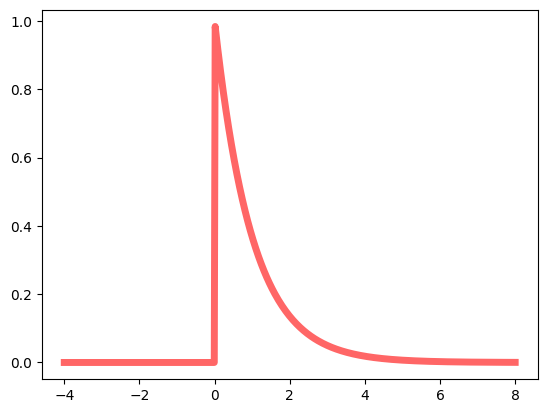

In [75]:
from scipy.stats import expon
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)

x = np.linspace(-4, 8, 500)
ax.plot(x, expon.pdf(x),
       'r-', lw=5, alpha=0.6, label='expon pdf')

In [76]:
exp_pdf_values = expon.pdf(x)

In [78]:
exp_pdf_values.shape

(500,)

In [82]:
exp_pdf_values

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [80]:
rhovaliid = kde(kernel, yiid1_exp, 0.1, x) # bandwidth = 0.1

In [81]:
rhovaliid.shape

(500,)

In [83]:
rhovaliid

array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0

In [84]:
mse = (np.square(rhovaliid - exp_pdf_values)).mean(axis=None) 

In [85]:
mse

0.0013710879417071662

### Laplace Distribution

PDF for x = 3.0: 0.024893534183931972
[0.18393972 0.13179857 0.0944378  0.06766764 0.04848598 0.03474173
 0.02489353 0.017837   0.01278077 0.00915782]


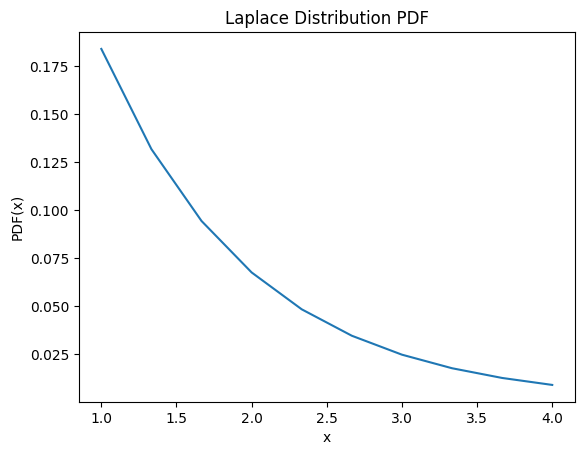

In [63]:
# https://www.askpython.com/python/examples/laplace-distribution-python
from scipy import stats
 
# Define location (mean) and scale parameters
loc = 0
scale = 1.0
 
# Create a Laplace distribution object
laplace_dist = stats.laplace(loc, scale)
 
# Calculate the PDF for a specific value (x = 3.0)
x = 3.0
pdf_value = laplace_dist.pdf(x)
 
print(f"PDF for x = {x}: {pdf_value}")
 
# Alternatively, calculate the PDF for an array of values
x_values = np.linspace(1.0, 4.0, 10)
pdf_values = laplace_dist.pdf(x_values)
print(pdf_values)
 
# Plot the PDF (using matplotlib)
import matplotlib.pyplot as plt
 
plt.plot(x_values, pdf_values)
plt.xlabel("x")
plt.ylabel("PDF(x)")
plt.title("Laplace Distribution PDF")
plt.show()

In [64]:
x_values = np.linspace(-4, 8, 500)
pdf_values = laplace_dist.pdf(x_values)
print(pdf_values)

[9.15781944e-03 9.38071696e-03 9.60903970e-03 9.84291972e-03
 1.00824923e-02 1.03278960e-02 1.05792726e-02 1.08367677e-02
 1.11005301e-02 1.13707124e-02 1.16474708e-02 1.19309654e-02
 1.22213601e-02 1.25188230e-02 1.28235259e-02 1.31356452e-02
 1.34553613e-02 1.37828592e-02 1.41183283e-02 1.44619625e-02
 1.48139606e-02 1.51745263e-02 1.55438679e-02 1.59221992e-02
 1.63097389e-02 1.67067111e-02 1.71133455e-02 1.75298772e-02
 1.79565471e-02 1.83936020e-02 1.88412946e-02 1.92998839e-02
 1.97696350e-02 2.02508197e-02 2.07437162e-02 2.12486097e-02
 2.17657920e-02 2.22955623e-02 2.28382270e-02 2.33940999e-02
 2.39635026e-02 2.45467642e-02 2.51442222e-02 2.57562221e-02
 2.63831179e-02 2.70252720e-02 2.76830558e-02 2.83568499e-02
 2.90470438e-02 2.97540367e-02 3.04782376e-02 3.12200652e-02
 3.19799486e-02 3.27583272e-02 3.35556513e-02 3.43723819e-02
 3.52089913e-02 3.60659635e-02 3.69437940e-02 3.78429906e-02
 3.87640732e-02 3.97075746e-02 4.06740405e-02 4.16640297e-02
 4.26781148e-02 4.371688

In [65]:
print(pdf_values.shape)

(500,)


In [66]:
yiid_laplace

array([[ 0.42125509],
       [ 1.94110217],
       [-0.23954822],
       ...,
       [ 0.22273007],
       [ 1.27002998],
       [ 0.59394328]])

In [67]:
rhovaliid = kde(kernel, yiid_laplace, 0.1, x_values)

In [68]:
rhovaliid

array([1.37583201e-003, 1.31988171e-003, 1.12790666e-003, 8.58578209e-004,
       5.82177094e-004, 3.51640522e-004, 1.89195704e-004, 9.06759626e-005,
       3.87116453e-005, 1.47217567e-005, 4.98707837e-006, 1.50487802e-006,
       4.04505992e-007, 9.68539123e-008, 2.06575079e-008, 3.92470699e-009,
       6.64209528e-010, 1.00131683e-010, 1.34464140e-011, 1.60845899e-012,
       1.71388649e-013, 1.62675695e-014, 1.37540893e-015, 1.03588026e-016,
       6.94953625e-018, 4.15308332e-019, 2.21082380e-020, 1.04854070e-021,
       4.97654623e-023, 1.41474638e-022, 3.17527789e-021, 6.42367029e-020,
       1.15760637e-018, 1.85826283e-017, 2.65718579e-016, 3.38458365e-015,
       3.84022911e-014, 3.88130318e-013, 3.49435121e-012, 2.80236105e-011,
       2.00193593e-010, 1.27392779e-009, 7.22117713e-009, 3.64619370e-008,
       1.63998557e-007, 6.57065804e-007, 2.34501841e-006, 7.45507811e-006,
       2.11118694e-005, 5.32561459e-005, 1.19668908e-004, 2.39530860e-004,
       4.27080928e-004, 6

In [69]:
print(rhovaliid.shape)

(500,)


In [70]:
rhovaliid-yiid_laplace

array([[-0.41987926, -0.41993521, -0.42012718, ..., -0.42125509,
        -0.42125509, -0.42125509],
       [-1.93972634, -1.93978229, -1.93997426, ..., -1.94110217,
        -1.94110217, -1.94110217],
       [ 0.24092406,  0.2408681 ,  0.24067613, ...,  0.23954822,
         0.23954822,  0.23954822],
       ...,
       [-0.22135423, -0.22141018, -0.22160216, ..., -0.22273007,
        -0.22273007, -0.22273007],
       [-1.26865414, -1.26871009, -1.26890207, ..., -1.27002998,
        -1.27002998, -1.27002998],
       [-0.59256745, -0.5926234 , -0.59281537, ..., -0.59394328,
        -0.59394328, -0.59394328]])

In [86]:
# another way: using MSE
mse = (np.square(rhovaliid - pdf_values)).mean(axis=None) 
# with omitting the ax parameter (or setting it to ax=None) the average is performed element-wise along the array, returning a scalar value
# https://stackoverflow.com/questions/16774849/mean-squared-error-in-numpy

In [87]:
print(mse)

0.017669768852039407


In [88]:
# integration: https://docs.scipy.org/doc/scipy/tutorial/integrate.html
import scipy.integrate as integrate
result = integrate.quad(mse, -np.inf, np.inf) # error: integrand has to be a callable object, e.g., a function (floats/numbers aren't callable)
print(result)

ValueError: invalid callable given

In [ ]:
result = integrate.quad(1, -np.inf, np.inf)
print(result)

ValueError: invalid callable given